In [25]:
import pandas as pd
import shap
import numpy as np
import imblearn
import copy

from math import floor
from xgboost import XGBClassifier

In [26]:
df = pd.read_excel('..\\..\\concat.xlsx')\
       .drop('file_name', axis='columns')\
       .drop('Unnamed: 0', axis='columns')

chapt_major = df.pop('chapt_major')

In [27]:
def sample(data:pd.DataFrame):
    original_data = copy.deepcopy(data)
    # original_data.index = [i.split('_')[0] for i in original_data.index]
     
    # balance dataset
    sm = imblearn.over_sampling.SMOTE()
    x_res, y_res = sm.fit_resample(original_data, original_data['game'])
    x_res.index = y_res
     
    proportion_in_whole_data_set = 0.3
    
    dataset_classified = [x_res.loc[i] for i in set(x_res.index)]
    n_test_samples = floor(dataset_classified[0].shape[0] * proportion_in_whole_data_set)
    # Due to the balanced dataset, one sub-dataset shape represents all.

    idx_for_test = [np.random.choice(range(0, i.shape[0]), (n_test_samples,), replace=False) for i in dataset_classified]
    test_x = pd.concat([dataset_classified[i].take(idx_for_test[i]) for i in range(len(dataset_classified))])
    test_y = test_x.index
    
    idx_for_train = [list(set(range(dataset_classified[sub].shape[0])).difference(idx_for_test[sub]))
                    for sub in range(len(dataset_classified))]
    train_x = pd.concat([dataset_classified[i].take(idx_for_train[i]) for i in range(len(dataset_classified))])
    train_y = train_x.index

    return train_x.drop('game', axis='columns'), \
        train_y, \
            test_x.drop('game', axis='columns'), \
                test_y

In [28]:
clf = XGBClassifier()
x, y, t_x, t_y = sample(df)
clf.fit(x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
explainer = shap.TreeExplainer(clf)

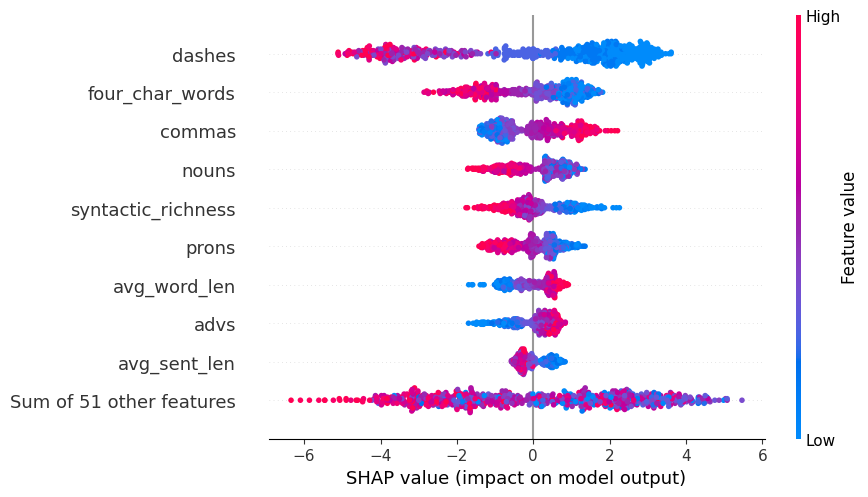

In [30]:
shap_values = explainer(x, y)
shap.plots.beeswarm(shap_values)

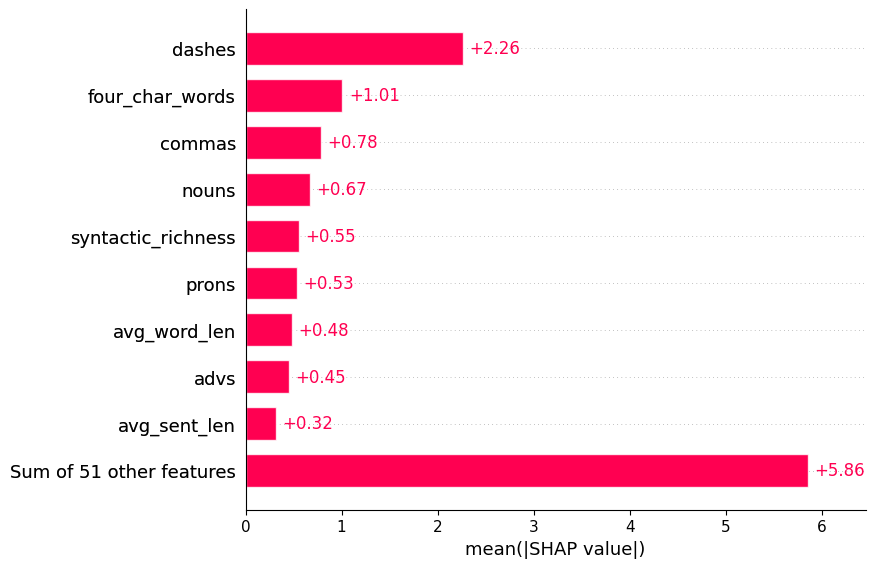

In [31]:
shap.plots.bar(shap_values)

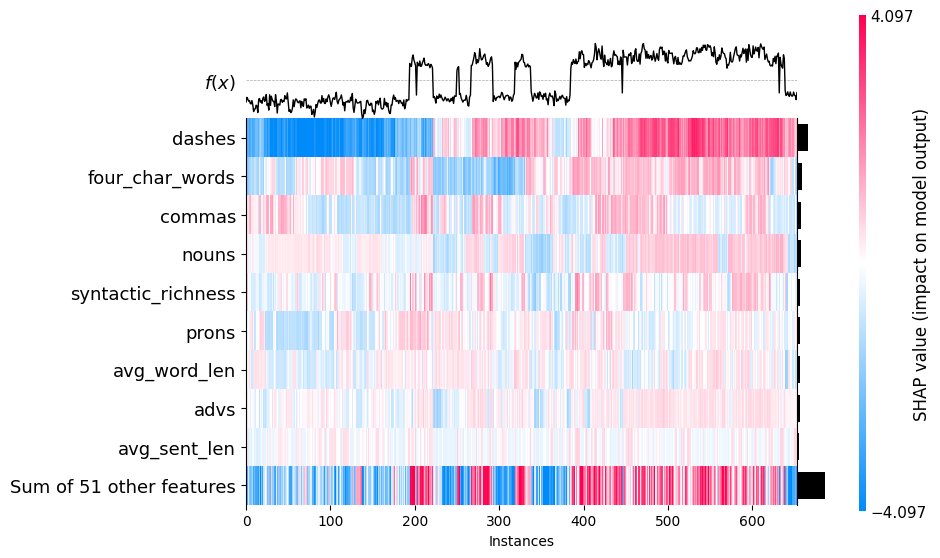

<Axes: xlabel='Instances'>

In [32]:
shap.plots.heatmap(shap_values)